In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from data_processor import series_to_supervised,evaluate
%matplotlib inline

## 读取数据，检查数据集

In [2]:
# load data
names = locals()

In [3]:
# list(os.listdir(dir_NWP))

In [4]:
dir_power = 'power_detrended'

name_index_power = pd.Series(os.listdir(dir_power)).map(lambda x:x[:-4])

for i in name_index_power:
    filename = 'power_detrended/'+str(i)+'.csv'
    names['data_%s' % i] = pd.read_csv(filename, index_col=3, parse_dates=True)
    names['power_%s' % i] = pd.DataFrame(names['data_%s' % i]['power_with_trend'])
    names['power_supervised_%s' % i] = series_to_supervised(names['power_%s' % i], 48, 16)

In [5]:
dir_NWP = 'nwp_refill'

name_index_NWP = list(os.listdir(dir_NWP))
name_index_NWP.remove('.DS_Store')
name_index_NWP = pd.Series(name_index_NWP).map(lambda x:x[3:-4])

for i in name_index_NWP:
    filename = 'nwp_refill/CN0'+str(i)+'.csv'
    names['NWP_%s' % i] = pd.read_csv(filename, index_col=0, parse_dates=True)

In [6]:
# power_66.index

In [7]:
len(power_66)

34992

### 功率数据集从2017.1.2至2018.12.31，取其中7.00-19.00的部分，长度34992

In [8]:
# NWP_016.index

In [9]:
# len(NWP_016)

### NWP数据集从2017.1.2至2019.3.7，比功率要多，取与功率数据相同的部分

In [10]:
# NWP_66 = NWP_016.loc[power_66.index]

In [11]:
# NWP_66.index

## 根据NWP的云量，初步确定每个时刻的天气状况的类别

In [12]:
cloud = pd.DataFrame(NWP_016.cloud_amount)

In [13]:
cloud['cloud_diff'] = cloud.diff(1)
cloud = cloud.fillna(0)

### 判断标准：云量大于90或者小于5 且 变化率小于1 

In [14]:
cloud['fluctuate'] = [0 if ((cloud.cloud_amount[i]>95 or cloud.cloud_amount[i]<5) and abs(cloud.cloud_diff[i])<1) 
                      else 1 
                      for i in range(len(cloud))]

In [15]:
cloud = cloud.loc[power_66.index]

In [16]:
index_stable = [x for x in cloud[cloud.fluctuate == 0].index if x < datetime.datetime(2019,1,1)]
index_fluc = [x for x in cloud[cloud.fluctuate == 1].index if x < datetime.datetime(2019,1,1)]

### 观察此判断标准下是否大致合理

#### 波动小的样本数量

In [17]:
len(index_stable)

19708

In [18]:
len(index_fluc)

15284

#### 观察具体曲线

In [19]:
power_stable = power_66.loc[index_stable]
power_fluc = power_66.loc[index_fluc]

/Users/mayuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


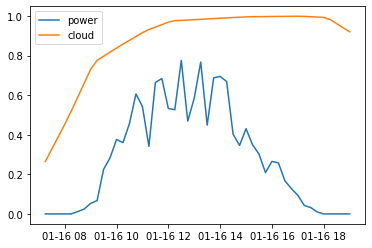

In [20]:
k = 15
plt.plot(power_66[48*(k-1):48*k]/20, label='power')
plt.plot(cloud.cloud_amount.loc[power_66[48*(k-1):48*k].index]/100, label='cloud')
plt.legend(loc='best')

In [21]:
power_observe = power_66.copy()
power_observe['fluc'] = cloud.loc[power_66.index]['fluctuate']

power_observe['stable'] = [-(power_observe['fluc'][i]-1)*power_observe['power_with_trend'][i] for i in range(len(power_observe))]
power_observe['fluc'] = [(power_observe['fluc'][i])*power_observe['power_with_trend'][i] for i in range(len(power_observe))]



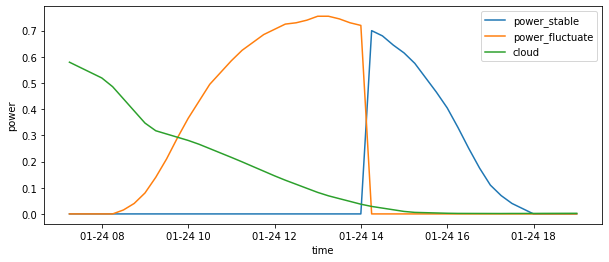

In [22]:
k = 23
graph = plt.figure(figsize=(10, 4))
ax = graph.add_subplot(111)
plt.plot(power_observe['stable'][48*(k-1):48*k]/20, label='power_stable')
plt.plot(power_observe['fluc'][48*(k-1):48*k]/20, label='power_fluctuate')
plt.plot(cloud.cloud_amount.loc[power_66[48*(k-1):48*k].index]/100, label='cloud')
plt.xlabel('time')
plt.ylabel('power')
plt.legend(loc='best')

## 构建波动小情况下的样本

In [23]:
index = power_66.index
scaler1 = MinMaxScaler(feature_range=(0,1))
power_66_normalized = pd.DataFrame(scaler1.fit_transform(power_66))
power_66_normalized['index'] = index
power_66_normalized = power_66_normalized.set_index('index')

In [24]:
power_66_supervised = series_to_supervised(power_66_normalized, 48, 16)
power_66_supervised.iloc[83:87,-20:]

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15)
index,,,,,,,,,,,,,,,,,,,,
2017-01-04 16:00:00,0.494808,0.432932,0.373207,0.323086,0.247404,0.180226,0.127954,0.087437,0.057574,0.031963,0.010654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-01-04 16:15:00,0.432932,0.373207,0.323086,0.247404,0.180226,0.127954,0.087437,0.057574,0.031963,0.010654,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-01-04 16:30:00,0.373207,0.323086,0.247404,0.180226,0.127954,0.087437,0.057574,0.031963,0.010654,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-01-04 16:45:00,0.323086,0.247404,0.180226,0.127954,0.087437,0.057574,0.031963,0.010654,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014906


In [25]:
index_of_inputs = list(range(16))+list(range(0,-8,-1))
inputs = power_66_supervised.iloc[:,:48]
outputs = power_66_supervised.iloc[:,48:]

In [26]:
for i in range(16):
    names['output_%s' % str(i+1)] = outputs.iloc[:,i]

In [27]:
for i in range(16):
    names['output_stable_%s' % str(i+1)] = names['output_%s' % str(i+1)].loc[list(map(lambda x:x+datetime.timedelta(minutes=15*i), index_stable))]
    names['output_stable_%s' % str(i+1)] = names['output_stable_%s' % str(i+1)].dropna()

/Users/mayuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [28]:
for i in range(16):
    names['input_stable_%s' % str(i+1)] = inputs.loc[names['output_stable_%s' % str(i+1)].index]

In [29]:
input_stable_1

,var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
index,,,,,,,,,,,,,,,,,,,,,
2017-01-04 16:00:00,0.323086,0.221793,0.136457,0.086336,0.055423,0.030913,0.010654,0.000000,0.000000,0.000000,...,0.693141,0.679285,0.664379,0.634516,0.596100,0.549181,0.494808,0.432932,0.373207,0.323086
2017-01-04 16:15:00,0.221793,0.136457,0.086336,0.055423,0.030913,0.010654,0.000000,0.000000,0.000000,0.000000,...,0.679285,0.664379,0.634516,0.596100,0.549181,0.494808,0.432932,0.373207,0.323086,0.247404
2017-01-04 16:30:00,0.136457,0.086336,0.055423,0.030913,0.010654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.664379,0.634516,0.596100,0.549181,0.494808,0.432932,0.373207,0.323086,0.247404,0.180226
2017-01-04 16:45:00,0.086336,0.055423,0.030913,0.010654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.634516,0.596100,0.549181,0.494808,0.432932,0.373207,0.323086,0.247404,0.180226,0.127954
2017-01-04 17:00:00,0.055423,0.030913,0.010654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.596100,0.549181,0.494808,0.432932,0.373207,0.323086,0.247404,0.180226,0.127954,0.087437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 14:15:00,0.745493,0.700954,0.651113,0.579003,0.506893,0.444327,0.363733,0.268293,0.195122,0.147402,...,0.835631,0.860021,0.871686,0.822906,0.820785,0.852598,0.825027,0.850477,0.849417,0.782609
2018-12-31 14:30:00,0.700954,0.651113,0.579003,0.506893,0.444327,0.363733,0.268293,0.195122,0.147402,0.142100,...,0.860021,0.871686,0.822906,0.820785,0.852598,0.825027,0.850477,0.849417,0.782609,0.802757
2018-12-31 14:45:00,0.651113,0.579003,0.506893,0.444327,0.363733,0.268293,0.195122,0.147402,0.142100,0.107105,...,0.871686,0.822906,0.820785,0.852598,0.825027,0.850477,0.849417,0.782609,0.802757,0.777306


## 模型选择

### 神经网络

In [31]:
from keras import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

# parameters
input_len = 48
output_step = 1
num_feature = 1
batch_size = 512
epochs = 100

test_len = 2880

for i in range(16):
    
    # split train and test(test one month)
    train_x,train_y = names['input_stable_%s' % str(i+1)][:-1000],names['output_stable_%s' % str(i+1)][:-1000]
    test_x,test_y = names['input_stable_%s' % str(i+1)][-1000:],names['output_stable_%s' % str(i+1)][-1000:]

    # design network
    model = Sequential()

    model.add(Dense(int(input_len/2),input_dim=input_len , activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(output_step, activation='relu'))

    adam = Adam(lr=0.001)

    model.compile(loss='mse', optimizer='adam')

    history = model.fit(train_x,train_y,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_split = 0.1,
                        callbacks=[
                            TensorBoard(log_dir='/tmp/tensorboard', write_graph=True),
                            EarlyStopping(monitor='val_loss', patience=5, mode='auto')
                        ]
                        )

    # make a prediction
    names['y_hat_%s' % str(i+1)] = model.predict(test_x)
    names['inv_yhat_%s' % str(i+1)] = scaler1.inverse_transform(names['y_hat_%s' % str(i+1)])

    test_y = pd.DataFrame(test_y)
    names['inv_y_%s' % str(i+1)] = scaler1.inverse_transform(test_y)

    names['rmse_%s' % str(i+1)] = evaluate(names['inv_y_%s' % str(i+1)],names['inv_yhat_%s' % str(i+1)])

Train on 16809 samples, validate on 1868 samples
Epoch 1/100
16809/16809 [==============================] - 1s 53us/step - loss: 0.0886 - val_loss: 0.0307
Epoch 2/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0483 - val_loss: 0.0158
Epoch 3/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0320 - val_loss: 0.0133
Epoch 4/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0252 - val_loss: 0.0115
Epoch 5/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0229 - val_loss: 0.0109
Epoch 6/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0212 - val_loss: 0.0100
Epoch 7/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0199 - val_loss: 0.0096
Epoch 8/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0182 - val_loss: 0.0089
Epoch 9/100
16809/16809 [==============================] - 0s 8us/step - loss: 0.0171 - val_loss: 0.0086
Epoch

16455/16455 [==============================] - 0s 7us/step - loss: 0.0146 - val_loss: 0.0107
Epoch 29/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0143 - val_loss: 0.0104
Epoch 30/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0144 - val_loss: 0.0110
Epoch 31/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0141 - val_loss: 0.0105
Epoch 32/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0142 - val_loss: 0.0105
Epoch 33/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0138 - val_loss: 0.0106
Epoch 34/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0140 - val_loss: 0.0102
Epoch 35/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0137 - val_loss: 0.0103
Epoch 36/100
16455/16455 [==============================] - 0s 7us/step - loss: 0.0135 - val_loss: 0.0105
Epoch 37/100
16455/16455 [==============================] -

16100/16100 [==============================] - 0s 8us/step - loss: 0.0165 - val_loss: 0.0140
Epoch 32/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0164 - val_loss: 0.0140
Epoch 33/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0161 - val_loss: 0.0136
Epoch 34/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0158 - val_loss: 0.0138
Epoch 35/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0162 - val_loss: 0.0135
Epoch 36/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0161 - val_loss: 0.0135
Epoch 37/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0160 - val_loss: 0.0136
Epoch 38/100
16100/16100 [==============================] - 0s 8us/step - loss: 0.0161 - val_loss: 0.0137
Epoch 39/100
16100/16100 [==============================] - 0s 7us/step - loss: 0.0158 - val_loss: 0.0139
Epoch 40/100
16100/16100 [==============================] -

15393/15393 [==============================] - 0s 8us/step - loss: 0.0334 - val_loss: 0.0257
Epoch 12/100
15393/15393 [==============================] - 0s 8us/step - loss: 0.0317 - val_loss: 0.0249
Epoch 13/100
15393/15393 [==============================] - 0s 7us/step - loss: 0.0305 - val_loss: 0.0241
Epoch 14/100
15393/15393 [==============================] - 0s 7us/step - loss: 0.0295 - val_loss: 0.0238
Epoch 15/100
15393/15393 [==============================] - 0s 7us/step - loss: 0.0292 - val_loss: 0.0235
Epoch 16/100
15393/15393 [==============================] - 0s 8us/step - loss: 0.0283 - val_loss: 0.0231
Epoch 17/100
15393/15393 [==============================] - 0s 8us/step - loss: 0.0277 - val_loss: 0.0229
Epoch 18/100
15393/15393 [==============================] - 0s 8us/step - loss: 0.0275 - val_loss: 0.0227
Epoch 19/100
15393/15393 [==============================] - 0s 7us/step - loss: 0.0272 - val_loss: 0.0227
Epoch 20/100
15393/15393 [==============================] -

14328/14328 [==============================] - 0s 8us/step - loss: 0.0501 - val_loss: 0.0372
Epoch 4/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0429 - val_loss: 0.0329
Epoch 5/100
14328/14328 [==============================] - 0s 8us/step - loss: 0.0386 - val_loss: 0.0298
Epoch 6/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0365 - val_loss: 0.0279
Epoch 7/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0352 - val_loss: 0.0267
Epoch 8/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0344 - val_loss: 0.0264
Epoch 9/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0335 - val_loss: 0.0259
Epoch 10/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0334 - val_loss: 0.0257
Epoch 11/100
14328/14328 [==============================] - 0s 7us/step - loss: 0.0327 - val_loss: 0.0256
Epoch 12/100
14328/14328 [==============================] - 0s 7u

13619/13619 [==============================] - 0s 8us/step - loss: 0.0301 - val_loss: 0.0220
Epoch 24/100
13619/13619 [==============================] - 0s 7us/step - loss: 0.0299 - val_loss: 0.0217
Epoch 25/100
13619/13619 [==============================] - 0s 8us/step - loss: 0.0299 - val_loss: 0.0216
Epoch 26/100
13619/13619 [==============================] - 0s 7us/step - loss: 0.0297 - val_loss: 0.0218
Epoch 27/100
13619/13619 [==============================] - 0s 8us/step - loss: 0.0295 - val_loss: 0.0229
Epoch 28/100
13619/13619 [==============================] - 0s 8us/step - loss: 0.0294 - val_loss: 0.0218
Epoch 29/100
13619/13619 [==============================] - 0s 8us/step - loss: 0.0292 - val_loss: 0.0219
Epoch 30/100
13619/13619 [==============================] - 0s 8us/step - loss: 0.0296 - val_loss: 0.0219
Train on 13264 samples, validate on 1474 samples
Epoch 1/100
13264/13264 [==============================] - 1s 78us/step - loss: 0.1635 - val_loss: 0.0682
Epoch 2/10

12905/12905 [==============================] - 0s 8us/step - loss: 0.0296 - val_loss: 0.0222
Epoch 23/100
12905/12905 [==============================] - 0s 8us/step - loss: 0.0292 - val_loss: 0.0211
Epoch 24/100
12905/12905 [==============================] - 0s 8us/step - loss: 0.0292 - val_loss: 0.0212
Epoch 25/100
12905/12905 [==============================] - 0s 7us/step - loss: 0.0287 - val_loss: 0.0219
Epoch 26/100
12905/12905 [==============================] - 0s 8us/step - loss: 0.0290 - val_loss: 0.0211
Epoch 27/100
12905/12905 [==============================] - 0s 8us/step - loss: 0.0284 - val_loss: 0.0210
Epoch 28/100
12905/12905 [==============================] - 0s 9us/step - loss: 0.0288 - val_loss: 0.0206
Epoch 29/100
12905/12905 [==============================] - 0s 8us/step - loss: 0.0285 - val_loss: 0.0212
Epoch 30/100
12905/12905 [==============================] - 0s 8us/step - loss: 0.0281 - val_loss: 0.0209
Epoch 31/100
12905/12905 [==============================] -

11838/11838 [==============================] - 0s 8us/step - loss: 0.0317 - val_loss: 0.0273
Epoch 6/100
11838/11838 [==============================] - 0s 8us/step - loss: 0.0312 - val_loss: 0.0259
Epoch 7/100
11838/11838 [==============================] - 0s 8us/step - loss: 0.0302 - val_loss: 0.0248
Epoch 8/100
11838/11838 [==============================] - 0s 9us/step - loss: 0.0295 - val_loss: 0.0237
Epoch 9/100
11838/11838 [==============================] - 0s 8us/step - loss: 0.0292 - val_loss: 0.0237
Epoch 10/100
11838/11838 [==============================] - 0s 8us/step - loss: 0.0287 - val_loss: 0.0238
Epoch 11/100
11838/11838 [==============================] - 0s 7us/step - loss: 0.0284 - val_loss: 0.0231
Epoch 12/100
11838/11838 [==============================] - 0s 7us/step - loss: 0.0280 - val_loss: 0.0230
Epoch 13/100
11838/11838 [==============================] - 0s 7us/step - loss: 0.0275 - val_loss: 0.0228
Epoch 14/100
11838/11838 [==============================] - 0s 

11484/11484 [==============================] - 0s 7us/step - loss: 0.0232 - val_loss: 0.0208
Epoch 46/100
11484/11484 [==============================] - 0s 8us/step - loss: 0.0235 - val_loss: 0.0209
Epoch 47/100
11484/11484 [==============================] - 0s 8us/step - loss: 0.0232 - val_loss: 0.0210
Epoch 48/100
11484/11484 [==============================] - 0s 7us/step - loss: 0.0232 - val_loss: 0.0205
Epoch 49/100
11484/11484 [==============================] - 0s 8us/step - loss: 0.0230 - val_loss: 0.0206
Epoch 50/100
11484/11484 [==============================] - 0s 8us/step - loss: 0.0228 - val_loss: 0.0207
Epoch 51/100
11484/11484 [==============================] - 0s 7us/step - loss: 0.0229 - val_loss: 0.0208
Epoch 52/100
11484/11484 [==============================] - 0s 8us/step - loss: 0.0227 - val_loss: 0.0209
Epoch 53/100
11484/11484 [==============================] - 0s 8us/step - loss: 0.0233 - val_loss: 0.0205


In [591]:
rmse = []
for i in range(16):
    rmse.append(names['rmse_%s'%str(i+1)])

In [592]:
rmse=np.array(rmse)

In [593]:
rmse.reshape(-1)

array([0.92852077, 1.35780661, 1.66447952, 2.23584927, 2.3967724 ,
       2.57332476, 2.61378391, 2.69889938, 2.92419248, 2.96987496,
       2.85015941, 2.61763551, 2.68451787, 2.58265647, 2.58631418,
       2.64123329])

In [594]:
acc_ = 1 - rmse/20
acc_.reshape(-1)

array([0.95357396, 0.93210967, 0.91677602, 0.88820754, 0.88016138,
       0.87133376, 0.8693108 , 0.86505503, 0.85379038, 0.85150625,
       0.85749203, 0.86911822, 0.86577411, 0.87086718, 0.87068429,
       0.86793834])

In [475]:
y_cdann = []
for i in range(16):
    y_cdann.append(names['inv_yhat_%s' % str(i+1)])

In [484]:
# y_cdann = pd.DataFrame(y_cdann)
y_cdann = pd.DataFrame(np.array(y_cdann).reshape(16,-1).T)

### 未分类的神经网络

In [485]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# parameters
input_len = 48
output_step = 16
num_feature = 1
batch_size = 512
epochs = 100
P_cap_66= 20

# load data
data_ = pd.read_csv('power_detrended/66.csv', index_col = 3, parse_dates=True)
power = pd.DataFrame(data_['power_with_trend'])
# power = pd.DataFrame(data['power_with_trend'])

# # choose 7.00-19.00 data
# name = power.columns
# data_chosen = list()
# for i in range(len(power)):
#     if i%96<=76 and i%96>28:
#         data_chosen.append(power.iloc[i].values.reshape(1,-1))
# power =  np.concatenate(data_chosen, axis=0)
# power = power[(power.index.time<=datetime.time(19,0)) & (power.index.time>=datetime.time(7,0))]
# power = pd.DataFrame(power)
# power.columns = name

# normalize features
scaler1 = MinMaxScaler(feature_range=(0,1))
power = pd.DataFrame(scaler1.fit_transform(power))

cols, names = list(), list()

# generate data
for i in range(input_len, 0 ,-1):
    cols.append(power.shift(i))
    names += [('df(t-%d)' % i)]

for i in range(output_step):
    cols.append(power.shift(-i))
    names += [('df(t+%d)' % i)]

data = pd.concat(cols, axis=1)
data.columns = names
data.dropna(inplace=True)
# data = data.values

# generate inputs and outputs
idx_of_input = list(range(16))+list(range(0,-8,-1))
input = data.iloc[:, :input_len]
input = input.iloc[:,idx_of_input]
output = data.iloc[:, -16:]

# split train and test(test one month)
k = -1000
train_x,train_y = input[:k],output[:k]
test_x,test_y = input[k:],output[k:]

input_dim = len(idx_of_input)
# design network
model = Sequential()

model.add(Dense(int(input_dim/2),input_dim=input_dim , activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))

adam = Adam(lr=0.001)

model.compile(loss='mse', optimizer='adam')

history = model.fit(train_x,train_y,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = 0.1,
                    callbacks=[
                        TensorBoard(log_dir='/tmp/tensorboard', write_graph=True),
                        EarlyStopping(monitor='val_loss', patience=5, mode='auto')
                    ]
                    )

# make a prediction
y_hat = model.predict(test_x)
inv_yhat = scaler1.inverse_transform(y_hat)

# test_y = test_y.reshape((len(test_y), output_step))
inv_y = scaler1.inverse_transform(test_y)

#calculate rmse
y_true = test_y.values
rmse = np.sqrt(np.average((inv_y-inv_yhat)**2,axis = 0))
acc = 1 - rmse/P_cap_66

print('detrended data','\n',rmse,'\n',acc)

Train on 30536 samples, validate on 3393 samples
Epoch 1/100
30536/30536 [==============================] - 1s 43us/step - loss: 0.1343 - val_loss: 0.1071
Epoch 2/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0888 - val_loss: 0.0569
Epoch 3/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0677 - val_loss: 0.0477
Epoch 4/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0599 - val_loss: 0.0416
Epoch 5/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0520 - val_loss: 0.0365
Epoch 6/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0473 - val_loss: 0.0341
Epoch 7/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0446 - val_loss: 0.0320
Epoch 8/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0421 - val_loss: 0.0311
Epoch 9/100
30536/30536 [==============================] - 0s 8us/step - loss: 0.0407 - val_loss: 0.0312
Epoch

### 采用原始数据的SVR

In [455]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [547]:
# normalize features
index = power_66.index
scaler = MinMaxScaler(feature_range=(0,1))
power_66_normalized = pd.DataFrame(scaler.fit_transform(power_66))
power_66_normalized['index'] = index
power_66_normalized = power_66_normalized.set_index('index')

power_66_supervised = series_to_supervised(power_66_normalized, 48, 16)

index_of_input = list(range(16)) + list(range(-8,0,1))
# index_of_input =  list(range(-8,0,1))
inputs = power_66_supervised.iloc[:,:48]
inputs = inputs.iloc[:,index_of_input]
outputs = power_66_supervised.iloc[:,48:]

In [548]:
for i in range(16):
    names['output_%s'%str(i+1)] = outputs.iloc[:,i]

In [558]:
train_len = 1000
test_len = 1000
for i in range(16):
    
    # split train and test(test one month)
    train_x,train_y = inputs[:train_len],names['output_%s'%str(i+1)][:train_len]
    test_x,test_y = inputs[1000:1000+test_len],names['output_%s'%str(i+1)][1000:1000+test_len]

    clf = SVR(kernel='rbf',
              gamma = 'auto'
              )

    clf.fit(train_x, train_y)

    names['y_hat_%s' % str(i+1)] = clf.predict(test_x)

    #calculate rmse
    names['inv_yhat_%s' % str(i+1)] = scaler.inverse_transform(names['y_hat_%s' % str(i+1)].reshape(-1,1))

    test_y = pd.DataFrame(test_y)
    names['inv_y_%s' % str(i+1)] = scaler.inverse_transform(test_y)

    names['rmse_%s' % str(i+1)] = evaluate(names['inv_y_%s' % str(i+1)],names['inv_yhat_%s' % str(i+1)])

In [559]:
rmse_svr = []
for i in range(16):
    rmse_svr.append(names['rmse_%s'%str(i+1)])
rmse_svr = np.array(rmse_svr).reshape(-1)
rmse_svr

array([1.36654403, 1.50871801, 1.61602001, 1.72386663, 1.86571657,
       1.98901452, 2.13909218, 2.2877851 , 2.43125011, 2.55549577,
       2.65376621, 2.7656417 , 2.84619928, 2.94083772, 3.01392379,
       3.13264301])

In [560]:
acc = 1-rmse_svr/20
acc

array([0.9316728 , 0.9245641 , 0.919199  , 0.91380667, 0.90671417,
       0.90054927, 0.89304539, 0.88561075, 0.87843749, 0.87222521,
       0.86731169, 0.86171792, 0.85769004, 0.85295811, 0.84930381,
       0.84336785])

In [284]:
# outputs.head()

In [227]:
# output_16

### 分类后的SVR（波动小的类）

In [561]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# names=locals()

In [587]:
index_of_input_svr = list(range(16)) + list(range(-8,0,1))
for i in range(16):
    
    # split train and test(test one month)
    names['input_stable_svr_%s'%str(i+1)] = names['input_stable_%s' % str(i+1)].iloc[:,index_of_input_svr]
    train_x_svr,train_y_svr = names['input_stable_svr_%s' % str(i+1)][:10000],names['output_stable_%s' % str(i+1)][:10000]
    test_x_svr,test_y_svr = names['input_stable_svr_%s' % str(i+1)][-1000:],names['output_stable_%s' % str(i+1)][-1000:]
    
    clf2 = SVR(kernel='rbf',
              gamma = 'auto',
#               verbose=True
              )

    clf2.fit(train_x_svr, train_y_svr)

    names['y_hat_svr_%s' % str(i+1)] = clf2.predict(test_x_svr)

    #calculate rmse
    names['inv_yhat_svr_%s' % str(i+1)] = scaler.inverse_transform(names['y_hat_svr_%s' % str(i+1)].reshape(-1,1))

    test_y_svr = pd.DataFrame(test_y_svr)
    names['inv_y_svr_%s' % str(i+1)] = scaler.inverse_transform(test_y_svr)

    names['rmse_svr_%s' % str(i+1)] = evaluate(names['inv_y_svr_%s' % str(i+1)],names['inv_yhat_svr_%s' % str(i+1)])

In [588]:
rmse_svr = []
for i in range(16):
    rmse_svr.append(names['rmse_svr_%s'%str(i+1)])
rmse_svr = np.array(rmse_svr).reshape(-1)
rmse_svr    

array([1.2704821 , 1.5511445 , 1.77972293, 2.00550682, 2.24999066,
       2.40297764, 2.51927151, 2.57632818, 2.79009476, 2.77527013,
       2.69567767, 2.61057294, 2.51489202, 2.516098  , 2.62445597,
       2.7205085 ])

In [589]:
acc_svr = 1-rmse_svr/20
acc_svr

array([0.93647589, 0.92244278, 0.91101385, 0.89972466, 0.88750047,
       0.87985112, 0.87403642, 0.87118359, 0.86049526, 0.86123649,
       0.86521612, 0.86947135, 0.8742554 , 0.8741951 , 0.8687772 ,
       0.86397457])

### 测试模型对训练样本和测试样本的表现

#### SVR

模型搭建，参数选择：

In [533]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# normalize features
index = power_66.index
scaler = MinMaxScaler(feature_range=(0,1))
power_66_normalized = pd.DataFrame(scaler.fit_transform(power_66))
power_66_normalized['index'] = index
power_66_normalized = power_66_normalized.set_index('index')

power_66_supervised = series_to_supervised(power_66_normalized, 48, 16)

index_of_input = list(range(16)) + list(range(-8,0,1))
# index_of_input =  list(range(-8,0,1))
inputs = power_66_supervised.iloc[:,:48]
inputs = inputs.iloc[:,index_of_input]
outputs = power_66_supervised.iloc[:,48:]

for i in range(16):
    names['output_%s'%str(i+1)] = outputs.iloc[:,i]

train_len = 1000
test_len = 1000

# 构建测试的集合
train_x,train_y = inputs[:train_len],names['output_%s'%str(i+1)][:train_len]

clf = SVR(kernel='rbf',
          gamma = 'auto'
          )

clf.fit(train_x, train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [534]:
# 构建测试的集合
test_x,test_y = inputs[train_len:],names['output_%s'%str(i+1)][train_len:]

In [535]:
error_svr = []
rmse_svr = []
for i in range(16):

    names['y_hat_%s' % str(i+1)] = clf.predict(inputs)

    #calculate rmse
    names['inv_yhat_%s' % str(i+1)] = scaler.inverse_transform(names['y_hat_%s' % str(i+1)].reshape(-1,1))

    names['output_%s'%str(i+1)] = pd.DataFrame(names['output_%s'%str(i+1)])
    names['inv_y_%s' % str(i+1)] = scaler.inverse_transform(names['output_%s'%str(i+1)])

    names['rmse_%s' % str(i+1)] = evaluate(names['inv_y_%s' % str(i+1)],names['inv_yhat_%s' % str(i+1)])
    rmse_svr.append(names['rmse_%s'%str(i+1)])
    
    names['error_%s' % str(i+1)] = np.abs(names['inv_y_%s' % str(i+1)]-names['inv_yhat_%s' % str(i+1)])
    error_svr.append(names['error_%s' % str(i+1)])  

In [536]:
error_svr = np.array(error_svr)
# error_svr

In [537]:
pd.DataFrame(error_svr.reshape(16,-1).T, index = inputs.index).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
index,,,,,,,,,,,,,,,,
2017-01-03 07:15:00,10.150079,10.150079,10.150079,10.150079,10.150079,9.959079,9.383079,8.786079,7.720079,7.464079,5.396079,2.689079,0.748079,0.722921,1.937921,2.704921
2017-01-03 07:30:00,10.792310,10.792310,10.792310,10.792310,10.601310,10.025310,9.428310,8.362310,8.106310,6.038310,3.331310,1.390310,0.080690,1.295690,2.062690,2.851690
2017-01-03 07:45:00,11.296694,11.296694,11.296694,11.105694,10.529694,9.932694,8.866694,8.610694,6.542694,3.835694,1.894694,0.423694,0.791306,1.558306,2.347306,3.221306
2017-01-03 08:00:00,11.745375,11.745375,11.554375,10.978375,10.381375,9.315375,9.059375,6.991375,4.284375,2.343375,0.872375,0.342625,1.109625,1.898625,2.772625,3.220625
2017-01-03 08:15:00,12.112310,11.921310,11.345310,10.748310,9.682310,9.426310,7.358310,4.651310,2.710310,1.239310,0.024310,0.742690,1.531690,2.405690,2.853690,3.215690


In [538]:
rmse_svr = np.array(rmse_svr).reshape(-1)
rmse_svr    

array([7.60608138, 7.36207737, 7.09835234, 6.81881753, 6.52802929,
       6.2299554 , 5.92932101, 5.63049725, 5.34212915, 5.07125385,
       4.82928668, 4.62460015, 4.46800029, 4.37057074, 4.33808484,
       4.37387198])

In [436]:
inv_y_1

array([[ 0.    ],
       [ 0.    ],
       [ 0.    ],
       ...,
       [14.6068],
       [13.1864],
       [12.084 ]])

In [437]:
inv_yhat_1

array([[ 1.00032161e+01],
       [ 1.08584309e+01],
       [ 1.14170861e+01],
       ...,
       [-1.20526475e-01],
       [ 9.01644681e-03],
       [ 6.73468610e-02]])

### 迭代